# Newtonian Tidal Disruption of Compact Binaries

We expect certain types of LIGO signals to have electromagnetic (EM) counterparts &mdash; bright, transient explosions visible to optical, radio, or high-energy telescopes at or sometime near the time of the gravitational wave signal. For example, up to 5-10% of neutron star binary mergers (either NS-NS or NS-BH) will probably produce detectable short-duration $\gamma$-ray bursts, and up to 20-50% of them will have optical or radio "afterglows" that last for a few days after the merger ([Metzger & Berger, 2012](http://iopscience.iop.org/article/10.1088/0004-637X/746/1/48/meta)). This happens because, during certain NS-BH mergers, the neutron star can be destroyed by tidal forces as it spirals toward the black hole, forming an accretion disk that powers the EM counterpart. But under what circumstances can this happen?

The following diagram illustrates the situation:

![](binary_diagram.png)

In this Jupyter notebook, we'll use Newtonian gravity to investigate the basic physics of tidal disruption when a neutron star of radius $R_{\rm NS}$ and mass $m_{\rm NS}$ spirals into a black hole of mass $m_{\rm BH}$, whose spin angular momentum $\mathbf{S}_{\rm BH}$ is aligned with the total orbital angular momentum. In particular, we'll try to understand when and how tidal disruption results in an accretion disk, and how this relates to the black hole's rate of spin. For a more detailed look at accretion-driven EM counterparts, we'll then compare this against e.g. [Foucart, 2012](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.86.124007).

---

First, we'll need the Python modules `numpy` and `matplotlib`:

In [1]:
# Imports.
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

Next, we'll need to define some physical constants (particularly $G$ and $c$) and set the neutron star mass to a typical value of $m_{\rm NS} = 1.4\,M_{\odot}$. We'll also want to choose a range of neutron star radii, which will act as a proxy for its equation of state.

In [2]:
# Physical constants.
G = 6.67408e-11  # Newton's constant in m^3 / kg / s
MSun = 1.989e30  # Solar mass in kg
c = 299792458.   # Speed of light in m/s
m_NS = 1.4*MSun  # NS mass in kg
R_NS = np.array([11e3, 12e3, 13e3])  # Neutron star radii to try, in meters

Now, it makes sense to define a couple of functions to do our heavy lifting. The first of these should locate the radius of the innermost stable circular orbit (or ISCO) given a black hole mass ($m_{\rm BH}$) and spin angular momentum (represented by the dimensionless number $\chi_{\rm BH} = G\vert\mathbf{S}_{\rm BH}\vert/Gm_{\rm BH}^2$). According to general relativity, this happens when objects in the binary are separated by a distance $a_{\rm ISCO}$ given by

\begin{equation}
f(\chi_{\rm BH}) \equiv \frac{c^2a_{\rm ISCO}}{Gm_{\rm BH}} = 3 + Z_2 - {\rm sgn}(\chi_{\rm BH}) \sqrt{(3-Z_1)(3+Z_1+2Z_2)}
\end{equation}

where $Z_1$ and $Z_2$ are defined as

\begin{align}
Z_1 &= 1 + (1 - \chi_{\rm BH}^2)^{1/3} \left[ (1+\chi_{\rm BH}^2)^{1/3} + (1-\chi_{\rm BH}^2)^{1/3} \right] \\
Z_2 &= \sqrt{3\chi_{\rm BH}^2 + Z_1^2}.
\end{align}

In [3]:
# Define a function that locates ISCO given the BH mass and spin.
def aISCO(m, chi):
    Z1 = 1 + (1 - chi**2)**(1./3) * ((1 + chi)**(1./3) + (1 - chi)**(1./3))
    Z2 = np.sqrt(3*chi**2 + Z1**2)
    f = 3 + Z2 - np.sign(chi) * np.sqrt((3 - Z1) * (3 + Z1 + 2*Z2))
    return f * G * m / c**2

Note: when you use this function, remember it is **vitally important** that $-1 < \chi_{\rm BH} < 1$, where a negative number means the black hole spins opposite the direction of the orbit. If you step outside of these limits, you will rip a hole through space and time. This would be very bad. **Do not rip a hole through space and time.**

The second function will locate the orbital separation at which tidal diruption occurs, $a_{\rm td}$. This is roughly identified as the point in the inspiral where tidal stresses acting on the neutron star due to the black hole overcome its own self-gravity, ripping this giant ultra-compact space atom to smithereens. To identify this point, remember that tidal stresses arise because of a nonzero force gradient across the neutron star. Along the axis separating both objects, when they are a distance $a$ apart, this is given by

\begin{equation*}
f_{\rm tide} = -GM\left[ \frac{1}{(a - R_{\rm NS})^2} - \frac{1}{(a + R_{\rm NS})^2} \right]
\end{equation*}

where $M = m_{\rm BH} + m_{\rm NS}$ is the total mass of the system. The neutron star self-gravity is of course

\begin{equation*}
f_{\rm grav} = \frac{G\mu}{R_{\rm NS}^2}
\end{equation*}

where $\mu = m_{\rm BH}m_{\rm NS}/M$ is the reduced mass. Thus, we can compute an array of force gradients at several test values of $a$, compare them to the self-gravity, then find a zero-crossing:

In [4]:
# Define a function for locating the tidal disruption point.
def disrupt(m1, R, m2=1.4*MSun, tol=1e-4):
    M = m1 + m2  # total mass in kg
    M0 = G * M / c**2  # total mass in m
    mu = m1 * m2 / M  # reduced mass in kg
    a_test = np.linspace(M0, 24*M0, int(1/tol))
    fgrav = G * mu / R**2  # NS self-gravity
    ftide = -G * M * (1/(a_test - R)**2 - 1/(a_test + R)**2)  # tidal force due to BH
    ftot = fgrav + ftide  # total force
    return a_test[ np.abs(ftot).argmin() ]

Now we're ready for the main body of the code, which simply makes repeated calls to our two functions `aISCO` and `disrupt` inside of a loop:

In [5]:
# Set array of primary masses to try.
masses = np.linspace(1.4*MSun, 18*m_NS, 1000)
atd = [ np.array([]) for i in xrange(len(R_NS)) ]

# Find the disruption point for each primary mass and several different spins.
for i in xrange(len(R_NS)):
    for m_BH in masses:
        atd[i] = np.append( atd[i], disrupt(m_BH, R_NS[i]) )

---
To visualize the relationship between tidal disruption and mass ratio, we can make a couple of plots. First, we want to know how the ratio between $a_{\rm td}$ and $a_{\rm ISCO}$ scales with the mass ratio $q = m_{\rm BH}/m_{\rm NS}$. Put simply, if tidal disruption occurs outside of ISCO then an accretion disk will form; otherwise, the neutron star plunges in without forming a disk (and thus, without producing an EM counterpart). So, the interesting question is: at what mass ratio is $a_{\rm td}/a_{\rm ISCO} = 1$?

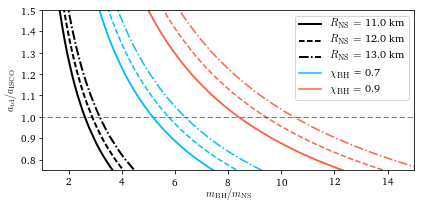

In [6]:
# Plot the ratio of a_td/a_ISCO as a function of direct mass ratio.
fig = plt.figure( figsize=(6, 3) )
ax = fig.add_subplot(1, 1, 1)
ls = ['solid', 'dashed', 'dashdot']
for i in xrange(len(R_NS)):
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0), 'k', linestyle=ls[i], linewidth=2.,
        label=r'$R_{\rm NS} =$ %.1f km' % (R_NS[i]/1e3))
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0.7), 'DeepSkyBlue', linestyle=ls[i])
    ax.plot(masses/m_NS, atd[i]/aISCO(masses, 0.9), 'Tomato', linestyle=ls[i])
ax.plot([0, 25], [1, 1], 'k--', linewidth=0.5)
ax.plot(masses/m_NS, atd[0]/aISCO(masses, 0.7), 'DeepSkyBlue', label=r'$\chi_{\rm BH}$ = 0.7')
ax.plot(masses/m_NS, atd[0]/aISCO(masses, 0.9), 'Tomato', label=r'$\chi_{\rm BH} =$ 0.9')
ax.set_xlim([1, 15])
ax.set_xlabel(r'$m_{\rm BH}/m_{\rm NS}$')
ax.set_ylim([0.75, 1.5])
ax.set_ylabel(r'$a_{\rm td}/a_{\rm ISCO}$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.legend(loc=1, fontsize=11, fancybox=True)
fig.tight_layout()
plt.savefig('disruption_point.pdf')

From this plot, we can convince ourselves that destroying a neutron star becomes easier as the neutron star gets less dense, which might not be surprising &mdash; but it also becomes easier as the black hole spins faster! Would it blow your mind if I told you that this happens because, when a black hole spins, it *drags space and time along with it*, causing even more extreme gravity? When you pick a fight with a raging monster the size of a city spinning faster than a kitchen blender, **you're going to lose that fight.**

Our second plot visualizes where the boundary between forming a disk and not forming a disk lies as a function of neutron star radius and black hole mass and spin. Remember: if there's a disk, there will be a bright explosion; if there isn't a disk, the system stays dark.

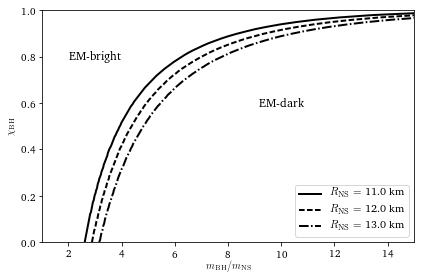

In [7]:
# For each NS radius, plot the boundary where a_td = a_ISCO as a function of BH mass and spin.
chi_BH = np.linspace(0, 0.999, 100)  # range of BH spins
q = [ np.array([]) for i in xrange(len(R_NS)) ]
for x in chi_BH:
    ISCO = aISCO(masses, x)
    for i in xrange(len(R_NS)):
        q[i] = np.append( q[i], masses[np.abs(atd[i]/ISCO - 1).argmin()] / m_NS )

fig = plt.figure( figsize=(6, 4) )
ax = fig.add_subplot(1, 1, 1)
for i in xrange(len(R_NS)):
    ax.plot(q[i], chi_BH, 'k', linestyle=ls[i], linewidth=2.,
            label=r'$R_{\rm NS} =$ %.1f km' % (R_NS[i]/1e3))
ax.set_xlim([1, 15])
ax.set_xlabel(r'$m_{\rm BH}/m_{\rm NS}$')
ax.set_ylim([0, 1])
ax.set_ylabel(r'$\chi_{\rm BH}$')
ax.annotate('EM-dark', xy=(10, 0.6), xycoords='data', size=12, ha="center", va="center")
ax.annotate('EM-bright', xy=(3, 0.8), xycoords='data', size=12, ha="center", va="center")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.legend(loc=4, fontsize=11, fancybox=True)
fig.tight_layout()
plt.savefig('qchi_diagram.pdf')

Note that this (very simplified!) model only uses Newtonian gravity, but it turns out to be a pretty good match for the results of [Foucart, 2012](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.86.124007). This is because two competing relativistic effects roughly cancel each other out: a compact object like a neutron star is harder to break in general relativity, but rotating black holes also have stronger tides. To see this, we can compare our model to Foucart's prediction for the mass of the accretion disk, Eq. (6):

\begin{equation}
\frac{m_{\rm disk}}{m_{\rm NS}} = \alpha (3q)^{1/3} \left(1 - \frac{2Gm_{\rm NS}}{c^2R_{\rm NS}}\right) - \beta \frac{a_{\rm ISCO}}{R_{\rm NS}}
\end{equation}

where $\alpha = 0.288$ and $\beta = 0.148$ are fitting parameters to a set of numerical simulations. The boundary between EM-bright and EM-dark occurs where $m_{\rm disk} = 0$, which relates $q$ to $a_{\rm ISCO}$ at fixed $R_{\rm NS}$:

\begin{equation}
q = \frac{1}{3} \left(\frac{\beta}{\alpha}\frac{a_{\rm ISCO}}{R_{\rm NS}}\right)^3 \left(1 - \frac{2Gm_{\rm NS}}{c^2R_{\rm NS}}\right)^{-3}.
\end{equation}

But watch out! There's a hidden dependence on $q$ on the right-hand side. Remember that $f(\chi_{\rm BH}) \equiv c^2a_{\rm ISCO}/Gm_{\rm BH}$ is a function of the black hole spin, so we can pull out a factor of $m_{\rm BH} = qm_{\rm NS}$ to get

\begin{equation}
q = 3^{1/2} \left[ \frac{\alpha}{\beta} \frac{1}{f(\chi_{\rm BH})} \frac{1-2C_{\rm NS}}{C_{\rm NS}} \right]^{3/2}.
\end{equation}

In this equation, $C_{\rm NS}=Gm_{\rm NS}/c^2R_{\rm NS}$ quantifies how compact the neutron star is.

Still with me? It's now possible to make an apples-to-apples comparison between Foucart's model and ours:

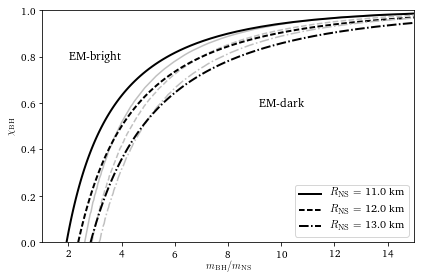

In [8]:
def q_Foucart(chi1, m1, R2, m2=1.4*MSun):
    const = 0.288 / 0.148  # Foucart's alpha/beta
    C = G * m2 / (c**2 * R2)  # compactness of the neutron star
    f = aISCO(c**2/G, chi1)
    return 3**0.5 * (const * (1/f) * (1 - 2*C) / C)**(3./2)

fig = plt.figure( figsize=(6, 4) )
ax = fig.add_subplot(1, 1, 1)
m_BH = np.linspace(1.4*MSun, 18*m_NS, len(chi_BH))  # we don't need as many points as before
for i in xrange(len(R_NS)):
    ax.plot(q[i], chi_BH, 'Silver', linestyle=ls[i], linewidth=1.5)
    ax.plot(q_Foucart(chi_BH, m_BH, R_NS[i]), chi_BH, 'k', linestyle=ls[i], linewidth=2.,
            label=r'$R_{\rm NS} =$ %.1f km' % (R_NS[i]/1e3))
ax.set_xlim([1, 15])
ax.set_xlabel(r'$m_{\rm BH}/m_{\rm NS}$')
ax.set_ylim([0, 1])
ax.set_ylabel(r'$\chi_{\rm BH}$')
ax.annotate('EM-dark', xy=(10, 0.6), xycoords='data', size=12, ha="center", va="center")
ax.annotate('EM-bright', xy=(3, 0.8), xycoords='data', size=12, ha="center", va="center")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
ax.legend(loc=4, fontsize=11, fancybox=True)
fig.tight_layout()
plt.savefig('qchi_diagram_foucart.pdf')

In this plot, the dark curves correspond to Foucart's model while the light gray ones correspond to our Newtonian model. We can see that at low $q$ our model underestimates the spin needed to destroy a neutron star, but again, that's hardly surprising: we never accounted for how compact the neutron star is, and compact objects are a lot sturdier in general relativity. Despite this, we were still able to get *remarkably* close using only Newtonian gravity!